In [4]:
import pandas as pd
import numpy as np
import duckdb
from xgboost import XGBRegressor
import warnings
from tqdm.notebook import tqdm

modelling_conn = duckdb.connect('modelling_db')
modelling_conn.execute("SET memory_limit = '16GB'")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# MODELOS

In [1]:
from modelling_utils.preprocessing import get_abt_estacoes_vizinhas
from training_utils import train_model
import duckdb
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

modelling_conn = duckdb.connect('modelling_db')
abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn,abt_estacoes_vizinhas_table_name='abt_estacoes_3_vizinhas')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Modelo 1

In [2]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=1,
    usar_n_estacoes_vizinhas=0,
    zero_undersampling_ratio=None,
    smote_oversampling=False,
    use_bi_model=False,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 1
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 0
🔄 Tipo de modelo: Modelo único

=== TREINAMENTO MODELO ÚNICO ===
📈 Preparando dados de treino e teste...
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros

📋 Resumo final:
   • Features de treino: (12734467, 39)
   • Features de teste: (5460499, 39)
   • Target treino - valores únicos: 267671
   • Target teste - valores únicos: 121575
🎯 Treinando modelo...
   • Features utilizadas: 37
   • Amostras de treino: 12734467
✅ Treinamento concluído!
🔮 Gerando predições...
⚖️  Truncando 665124 predições negativas para 0
📊 Predições geradas: 5460499
   • Valor mín: 0.000
   • Valor máx: 139.553
   • Média: 3.736
📋 Computando métricas de comparação...
✅ Comparação concluída!
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Model

## Modelo 2

In [3]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=2,
    usar_n_estacoes_vizinhas=1,
    zero_undersampling_ratio=None,
    smote_oversampling=False,
    use_bi_model=False,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 2
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 1
🔄 Tipo de modelo: Modelo único

=== TREINAMENTO MODELO ÚNICO ===
📈 Preparando dados de treino e teste...
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 1 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Dataset expandido para 45 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros

📋 Resumo final:
   • Features de treino: (12734467, 44)
   • Features de teste: (5460499, 44)
   • Target treino - valores únicos: 267671
   • Target teste - valores únicos: 121575
🎯 Treinando modelo...
   • Features utilizadas: 42
   • Amostras de treino: 12734467
✅ Treinamento concluído!
🔮 Gerando predições...
⚖️  Truncando 735819 predições negativas para 0
📊 Predições geradas: 5460499
   • Valor mín: 0.000
   • Valor máx: 155.405
   • Média: 3.730
📋 Computando métricas de comparação...
✅ Comparação concluída!
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_2.pkl
   • Comparação: comparisons/comparison_2.pkl

🎉 Processo concluído com sucesso para modelo 2!


## Modelo 3

In [4]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=3,
    usar_n_estacoes_vizinhas=1,
    zero_undersampling_ratio=1,
    smote_oversampling=False,
    use_bi_model=False,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 3
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 1
🔄 Tipo de modelo: Modelo único

=== TREINAMENTO MODELO ÚNICO ===
📈 Preparando dados de treino e teste...
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 1 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Dataset expandido para 45 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros
⚖️  Aplicando undersampling com ratio 1...
📉 Tamanho reduzido de 12734467 para 8206094 registros

📋 Resumo final:
   • Features de treino: (8206094, 44)
   • Features de teste: (5460499, 44)
   • Target treino - valores únicos: 175175
   • Target teste - valores únicos: 121575

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.775, Mediana: 0.100
   • Teste  - Média: 3.716, Mediana: 0.000
   • Zeros no treino: 4,101,399 (50.0%)
   • Zeros no teste: 3,702,686 (67.8%)
🎯 Treinando modelo...
   • Features utilizadas: 42
   • Amostras de treino: 8206094
✅ Treinamento concluído!
🔮 Gerando predições...
⚖️  Truncando 705974 predições negativas para 0
📊 Predições geradas: 5460499
   • Valor mín: 0.000
   • Valor máx: 168.771
   • Média: 4.225
📋 Computando métricas de comparação...
✅ Comparação concluída!
💾 Salvando modelo e comparação...


## Modelo 4

In [5]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=4,
    usar_n_estacoes_vizinhas=1,
    zero_undersampling_ratio=1,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 4
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 1
🔄 Tipo de modelo: Bi-model

=== TREINAMENTO BI-MODEL (threshold=0.5) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 11959652 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 11959652 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 1 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Dataset expandido para 45 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 8370264 registros | Teste: 3589388 registros
⚖️  Aplicando undersampling com ratio 1...
📉 Tamanho reduzido de 8370264 para 5670662 registros

📋 Resumo final:
   • Features de treino: (5670662, 44)
   • Features de teste: (3589388, 44)
   • Target treino - valores únicos: 170428
   • Target teste - valores únicos: 117636

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.575, Mediana: 0.100
   • Teste  - Média: 3.685, Mediana: 0.000
   • Zeros no treino: 2,833,355 (50.0%)
   • Zeros no teste: 2,393,756 (66.7%)
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 1 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Dataset expandido para 45 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros
⚖️  Aplicando undersampling com ratio 1...
📉 Tamanho reduzido de 12734467 para 8206094 registros

📋 Resumo final:
   • Features de treino: (8206094, 44)
   • Features de teste: (5460499, 44)
   • Target treino - valores únicos: 175175
   • Target teste - valores únicos: 121575

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.775, Mediana: 0.100
   • Teste  - Média: 3.716, Mediana: 0.000
   • Zeros no treino: 4,101,399 (50.0%)
   • Zeros no teste: 3,702,686 (67.8%)
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 42 features, 5670662 amostras
   • sem_vizinha: 42 features, 8206094 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 594303 predições negativas para 0
   • com_vizinha: 3589388 predições (média: 3.991)
⚖️  sem_vizinha: Truncando 705974 predições negativas para 0
   • sem_vizinha: 5460499 predições (média: 4.225)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_4.pkl
   • Comparação: comparisons/comparison_4.pkl

🎉 Processo concluído com sucesso para modelo 4!


## Modelo 5

In [9]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=5,
    usar_n_estacoes_vizinhas=1,
    zero_undersampling_ratio=None,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 5
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 1
🔄 Tipo de modelo: Bi-model

=== TREINAMENTO BI-MODEL (threshold=0.5) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 11959652 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 11959652 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 1 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Dataset expandido para 45 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 8370264 registros | Teste: 3589388 registros

📋 Resumo final:
   • Features de treino: (8370264, 44)
   • Features de teste: (3589388, 44)
   • Target treino - valores únicos: 261676
   • Target teste - valores únicos: 117636
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 1 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Dataset expandido para 45 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros

📋 Resumo final:
   • Features de treino: (12734467, 44)
   • Features de teste: (5460499, 44)
   • Target treino - valores únicos: 267671
   • Target teste - valores únicos: 121575
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 42 features, 8370264 amostras
   • sem_vizinha: 42 features, 12734467 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 606706 predições negativas para 0
   • com_vizinha: 3589388 predições (média: 3.653)
⚖️  sem_vizinha: Truncando 735819 predições negativas para 0
   • sem_vizinha: 5460499 predições (média: 3.730)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_5.pkl
   • Comparação: comparisons/comparison_5.pkl

🎉 Processo concluído com sucesso para modelo 5!


## Modelo 6

In [14]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=6,
    usar_n_estacoes_vizinhas=1,
    zero_undersampling_ratio=2,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 6
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 1
🔄 Tipo de modelo: Bi-model
⚖️  Zero undersampling ratio: 2 (zeros por não-zero)

=== TREINAMENTO BI-MODEL (threshold=0.5) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 11959652 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 11959652 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 1 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Dataset expandido para 45 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 8370264 registros | Teste: 3589388 registros
⚖️  Aplicando undersampling com ratio 2...
    💡 Isso significa: 2 zeros para cada 1 não-zero
📉 Antes: 5,534,933 zeros, 2,835,331 não-zeros
📊 Depois: 5,536,263 zeros, 2,834,001 não-zeros
📈 Ratio real: 1.95 | Tamanho: 8370264 → 8370264

📋 Resumo final:
   • Features de treino: (8370264, 44)
   • Features de teste: (3589388, 44)
   • Target treino - valores únicos: 170981
   • Target teste - valores únicos: 117636

📊 Estatísticas do target após processamento:
   • Treino - Média: 3.775, Mediana: 0.000
   • Teste  - Média: 3.685, Mediana: 0.000
   • Zeros no treino: 5,536,263 (66.1%)
   • Zeros no teste: 2,393,756 (66.7%)
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 1 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Dataset expandido para 45 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros
⚖️  Aplicando undersampling com ratio 2...
    💡 Isso significa: 2 zeros para cada 1 não-zero
📉 Antes: 8,631,420 zeros, 4,103,047 não-zeros
📊 Depois: 8,208,346 zeros, 4,100,795 não-zeros
📈 Ratio real: 2.00 | Tamanho: 12734467 → 12309141

📋 Resumo final:
   • Features de treino: (12309141, 44)
   • Features de teste: (5460499, 44)
   • Target treino - valores únicos: 174771
   • Target teste - valores únicos: 121575

📊 Estatísticas do target após processamento:
   • Treino - Média: 3.849, Mediana: 0.000
   • Teste  - Média: 3.716, Mediana: 0.000
   • Zeros no treino: 8,208,346 (66.7%)
   • Zeros no teste: 3,702,686 (67.8%)
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 42 features, 8370264 amostras
   • sem_vizinha: 42 features, 12309141 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 541845 predições negativas para 0
   • com_vizinha: 3589388 predições (média: 3.651)
⚖️  sem_vizinha: Truncando 812541 predições negativas para 0
   • sem_vizinha: 5460499 predições (média: 3.767)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_6.pkl
   • Comparação: comparisons/comparison_6.pkl

🎉 Processo concluído com sucesso para modelo 6!


## Modelo 7

In [15]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=7,
    usar_n_estacoes_vizinhas=1,
    zero_undersampling_ratio=5,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 7
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 1
🔄 Tipo de modelo: Bi-model
⚖️  Zero undersampling ratio: 5 (zeros por não-zero)

=== TREINAMENTO BI-MODEL (threshold=0.5) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 11959652 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 11959652 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 1 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Dataset expandido para 45 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 8370264 registros | Teste: 3589388 registros
⚖️  Aplicando undersampling com ratio 5...
    💡 Isso significa: 5 zeros para cada 1 não-zero
📉 Antes: 5,534,933 zeros, 2,835,331 não-zeros
📊 Depois: 5,534,524 zeros, 2,835,740 não-zeros
📈 Ratio real: 1.95 | Tamanho: 8370264 → 8370264

📋 Resumo final:
   • Features de treino: (8370264, 44)
   • Features de teste: (3589388, 44)
   • Target treino - valores únicos: 170622
   • Target teste - valores únicos: 117636

📊 Estatísticas do target após processamento:
   • Treino - Média: 3.784, Mediana: 0.000
   • Teste  - Média: 3.685, Mediana: 0.000
   • Zeros no treino: 5,534,524 (66.1%)
   • Zeros no teste: 2,393,756 (66.7%)
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 1 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Dataset expandido para 45 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros
⚖️  Aplicando undersampling com ratio 5...
    💡 Isso significa: 5 zeros para cada 1 não-zero
📉 Antes: 8,631,420 zeros, 4,103,047 não-zeros
📊 Depois: 8,630,429 zeros, 4,104,038 não-zeros
📈 Ratio real: 2.10 | Tamanho: 12734467 → 12734467

📋 Resumo final:
   • Features de treino: (12734467, 44)
   • Features de teste: (5460499, 44)
   • Target treino - valores únicos: 174731
   • Target teste - valores únicos: 121575

📊 Estatísticas do target após processamento:
   • Treino - Média: 3.723, Mediana: 0.000
   • Teste  - Média: 3.716, Mediana: 0.000
   • Zeros no treino: 8,630,429 (67.8%)
   • Zeros no teste: 3,702,686 (67.8%)
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 42 features, 8370264 amostras
   • sem_vizinha: 42 features, 12734467 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 519200 predições negativas para 0
   • com_vizinha: 3589388 predições (média: 3.614)
⚖️  sem_vizinha: Truncando 682425 predições negativas para 0
   • sem_vizinha: 5460499 predições (média: 3.729)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_7.pkl
   • Comparação: comparisons/comparison_7.pkl

🎉 Processo concluído com sucesso para modelo 7!


## Modelo 8

In [16]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=8,
    usar_n_estacoes_vizinhas=2,
    zero_undersampling_ratio=1,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 8
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 2
🔄 Tipo de modelo: Bi-model
⚖️  Zero undersampling ratio: 1 (zeros por não-zero)

=== TREINAMENTO BI-MODEL (threshold=0.5) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 11959652 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 11959652 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 2 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Dataset expandido para 50 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 8370264 registros | Teste: 3589388 registros
⚖️  Aplicando undersampling com ratio 1...
    💡 Isso significa: 1 zeros para cada 1 não-zero
📉 Antes: 5,534,933 zeros, 2,835,331 não-zeros
📊 Depois: 2,835,773 zeros, 2,834,889 não-zeros
📈 Ratio real: 1.00 | Tamanho: 8370264 → 5670662

📋 Resumo final:
   • Features de treino: (5670662, 49)
   • Features de teste: (3589388, 49)
   • Target treino - valores únicos: 170674
   • Target teste - valores únicos: 117636

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.569, Mediana: 0.000
   • Teste  - Média: 3.685, Mediana: 0.000
   • Zeros no treino: 2,835,773 (50.0%)
   • Zeros no teste: 2,393,756 (66.7%)
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 2 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Dataset expandido para 50 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros
⚖️  Aplicando undersampling com ratio 1...
    💡 Isso significa: 1 zeros para cada 1 não-zero
📉 Antes: 8,631,420 zeros, 4,103,047 não-zeros
📊 Depois: 4,104,063 zeros, 4,102,031 não-zeros
📈 Ratio real: 1.00 | Tamanho: 12734467 → 8206094

📋 Resumo final:
   • Features de treino: (8206094, 49)
   • Features de teste: (5460499, 49)
   • Target treino - valores únicos: 175049
   • Target teste - valores únicos: 121575

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.770, Mediana: 0.000
   • Teste  - Média: 3.716, Mediana: 0.000
   • Zeros no treino: 4,104,063 (50.0%)
   • Zeros no teste: 3,702,686 (67.8%)
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 47 features, 5670662 amostras
   • sem_vizinha: 47 features, 8206094 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 589588 predições negativas para 0
   • com_vizinha: 3589388 predições (média: 3.903)
⚖️  sem_vizinha: Truncando 694373 predições negativas para 0
   • sem_vizinha: 5460499 predições (média: 4.202)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_8.pkl
   • Comparação: comparisons/comparison_8.pkl

🎉 Processo concluído com sucesso para modelo 8!


## Modelo 9

In [17]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=9,
    usar_n_estacoes_vizinhas=3,
    zero_undersampling_ratio=1,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 9
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 3
🔄 Tipo de modelo: Bi-model
⚖️  Zero undersampling ratio: 1 (zeros por não-zero)

=== TREINAMENTO BI-MODEL (threshold=0.5) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 11959652 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 11959652 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 8370264 registros | Teste: 3589388 registros
⚖️  Aplicando undersampling com ratio 1...
    💡 Isso significa: 1 zeros para cada 1 não-zero
📉 Antes: 5,534,933 zeros, 2,835,331 não-zeros
📊 Depois: 2,835,106 zeros, 2,835,556 não-zeros
📈 Ratio real: 1.00 | Tamanho: 8370264 → 5670662

📋 Resumo final:
   • Features de treino: (5670662, 54)
   • Features de teste: (3589388, 54)
   • Target treino - valores únicos: 170613
   • Target teste - valores únicos: 117636

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.579, Mediana: 0.050
   • Teste  - Média: 3.685, Mediana: 0.000
   • Zeros no treino: 2,835,106 (50.0%)
   • Zeros no teste: 2,393,756 (66.7%)
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros
⚖️  Aplicando undersampling com ratio 1...
    💡 Isso significa: 1 zeros para cada 1 não-zero
📉 Antes: 8,631,420 zeros, 4,103,047 não-zeros
📊 Depois: 4,103,404 zeros, 4,102,690 não-zeros
📈 Ratio real: 1.00 | Tamanho: 12734467 → 8206094

📋 Resumo final:
   • Features de treino: (8206094, 54)
   • Features de teste: (5460499, 54)
   • Target treino - valores únicos: 174908
   • Target teste - valores únicos: 121575

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.771, Mediana: 0.000
   • Teste  - Média: 3.716, Mediana: 0.000
   • Zeros no treino: 4,103,404 (50.0%)
   • Zeros no teste: 3,702,686 (67.8%)
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 52 features, 5670662 amostras
   • sem_vizinha: 52 features, 8206094 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 456881 predições negativas para 0
   • com_vizinha: 3589388 predições (média: 3.980)
⚖️  sem_vizinha: Truncando 799877 predições negativas para 0
   • sem_vizinha: 5460499 predições (média: 4.201)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_9.pkl
   • Comparação: comparisons/comparison_9.pkl

🎉 Processo concluído com sucesso para modelo 9!


## Modelo 10

In [18]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=10,
    usar_n_estacoes_vizinhas=3,
    zero_undersampling_ratio=None,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 10
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 3
🔄 Tipo de modelo: Bi-model

=== TREINAMENTO BI-MODEL (threshold=0.5) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 11959652 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 11959652 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 8370264 registros | Teste: 3589388 registros

📋 Resumo final:
   • Features de treino: (8370264, 54)
   • Features de teste: (3589388, 54)
   • Target treino - valores únicos: 261676
   • Target teste - valores únicos: 117636
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros

📋 Resumo final:
   • Features de treino: (12734467, 54)
   • Features de teste: (5460499, 54)
   • Target treino - valores únicos: 267671
   • Target teste - valores únicos: 121575
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 52 features, 8370264 amostras
   • sem_vizinha: 52 features, 12734467 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 597303 predições negativas para 0
   • com_vizinha: 3589388 predições (média: 3.621)
⚖️  sem_vizinha: Truncando 839274 predições negativas para 0
   • sem_vizinha: 5460499 predições (média: 3.729)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_10.pkl
   • Comparação: comparisons/comparison_10.pkl

🎉 Processo concluído com sucesso para modelo 10!


## Modelo 11

In [19]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=11,
    usar_n_estacoes_vizinhas=3,
    zero_undersampling_ratio=1,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.25,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 11
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 3
🔄 Tipo de modelo: Bi-model
⚖️  Zero undersampling ratio: 1 (zeros por não-zero)

=== TREINAMENTO BI-MODEL (threshold=0.25) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 17464806 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 17464806 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12223439 registros | Teste: 5241367 registros
⚖️  Aplicando undersampling com ratio 1...
    💡 Isso significa: 1 zeros para cada 1 não-zero
📉 Antes: 8,234,961 zeros, 3,988,478 não-zeros
📊 Depois: 3,987,104 zeros, 3,989,852 não-zeros
📈 Ratio real: 1.00 | Tamanho: 12223439 → 7976956

📋 Resumo final:
   • Features de treino: (7976956, 54)
   • Features de teste: (5241367, 54)
   • Target treino - valores únicos: 174795
   • Target teste - valores únicos: 120692

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.763, Mediana: 0.100
   • Teste  - Média: 3.657, Mediana: 0.000
   • Zeros no treino: 3,987,104 (50.0%)
   • Zeros no teste: 3,569,814 (68.1%)
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros
⚖️  Aplicando undersampling com ratio 1...
    💡 Isso significa: 1 zeros para cada 1 não-zero
📉 Antes: 8,631,420 zeros, 4,103,047 não-zeros
📊 Depois: 4,102,661 zeros, 4,103,433 não-zeros
📈 Ratio real: 1.00 | Tamanho: 12734467 → 8206094

📋 Resumo final:
   • Features de treino: (8206094, 54)
   • Features de teste: (5460499, 54)
   • Target treino - valores únicos: 174974
   • Target teste - valores únicos: 121575

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.772, Mediana: 0.040
   • Teste  - Média: 3.716, Mediana: 0.000
   • Zeros no treino: 4,102,661 (50.0%)
   • Zeros no teste: 3,702,686 (67.8%)
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 52 features, 7976956 amostras
   • sem_vizinha: 52 features, 8206094 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 500027 predições negativas para 0
   • com_vizinha: 5241367 predições (média: 4.043)
⚖️  sem_vizinha: Truncando 741336 predições negativas para 0
   • sem_vizinha: 5460499 predições (média: 4.201)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_11.pkl
   • Comparação: comparisons/comparison_11.pkl

🎉 Processo concluído com sucesso para modelo 11!


## Modelo 12

In [20]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=12,
    usar_n_estacoes_vizinhas=3,
    zero_undersampling_ratio=1,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.75,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 12
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 3
🔄 Tipo de modelo: Bi-model
⚖️  Zero undersampling ratio: 1 (zeros por não-zero)

=== TREINAMENTO BI-MODEL (threshold=0.75) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 3848632 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 3848632 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 2693414 registros | Teste: 1155218 registros
⚖️  Aplicando undersampling com ratio 1...
    💡 Isso significa: 1 zeros para cada 1 não-zero
📉 Antes: 1,688,883 zeros, 1,004,531 não-zeros
📊 Depois: 1,004,427 zeros, 1,004,635 não-zeros
📈 Ratio real: 1.00 | Tamanho: 2693414 → 2009062

📋 Resumo final:
   • Features de treino: (2009062, 54)
   • Features de teste: (1155218, 54)
   • Target treino - valores únicos: 105817
   • Target teste - valores únicos: 74127

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.100, Mediana: 0.050
   • Teste  - Média: 3.841, Mediana: 0.000
   • Zeros no treino: 1,004,427 (50.0%)
   • Zeros no teste: 722,525 (62.5%)
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros
⚖️  Aplicando undersampling com ratio 1...
    💡 Isso significa: 1 zeros para cada 1 não-zero
📉 Antes: 8,631,420 zeros, 4,103,047 não-zeros
📊 Depois: 4,103,199 zeros, 4,102,895 não-zeros
📈 Ratio real: 1.00 | Tamanho: 12734467 → 8206094

📋 Resumo final:
   • Features de treino: (8206094, 54)
   • Features de teste: (5460499, 54)
   • Target treino - valores únicos: 175264
   • Target teste - valores únicos: 121575

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.777, Mediana: 0.000
   • Teste  - Média: 3.716, Mediana: 0.000
   • Zeros no treino: 4,103,199 (50.0%)
   • Zeros no teste: 3,702,686 (67.8%)
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 52 features, 2009062 amostras
   • sem_vizinha: 52 features, 8206094 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 203784 predições negativas para 0
   • com_vizinha: 1155218 predições (média: 4.029)
⚖️  sem_vizinha: Truncando 741062 predições negativas para 0
   • sem_vizinha: 5460499 predições (média: 4.199)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_12.pkl
   • Comparação: comparisons/comparison_12.pkl

🎉 Processo concluído com sucesso para modelo 12!


## Modelo 13

In [21]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=13,
    usar_n_estacoes_vizinhas=3,
    zero_undersampling_ratio=1,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.85,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 13
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 3
🔄 Tipo de modelo: Bi-model
⚖️  Zero undersampling ratio: 1 (zeros por não-zero)

=== TREINAMENTO BI-MODEL (threshold=0.85) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 1630189 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 1630189 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 1140832 registros | Teste: 489357 registros
⚖️  Aplicando undersampling com ratio 1...
    💡 Isso significa: 1 zeros para cada 1 não-zero
📉 Antes: 713,880 zeros, 426,952 não-zeros
📊 Depois: 426,495 zeros, 427,409 não-zeros
📈 Ratio real: 1.00 | Tamanho: 1140832 → 853904

📋 Resumo final:
   • Features de treino: (853904, 54)
   • Features de teste: (489357, 54)
   • Target treino - valores únicos: 44183
   • Target teste - valores únicos: 31027

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.162, Mediana: 0.100
   • Teste  - Média: 3.917, Mediana: 0.000
   • Zeros no treino: 426,495 (49.9%)
   • Zeros no teste: 304,436 (62.2%)
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros
⚖️  Aplicando undersampling com ratio 1...
    💡 Isso significa: 1 zeros para cada 1 não-zero
📉 Antes: 8,631,420 zeros, 4,103,047 não-zeros
📊 Depois: 4,099,806 zeros, 4,106,288 não-zeros
📈 Ratio real: 1.00 | Tamanho: 12734467 → 8206094

📋 Resumo final:
   • Features de treino: (8206094, 54)
   • Features de teste: (5460499, 54)
   • Target treino - valores únicos: 174983
   • Target teste - valores únicos: 121575

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.772, Mediana: 0.100
   • Teste  - Média: 3.716, Mediana: 0.000
   • Zeros no treino: 4,099,806 (50.0%)
   • Zeros no teste: 3,702,686 (67.8%)
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 52 features, 853904 amostras
   • sem_vizinha: 52 features, 8206094 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 107302 predições negativas para 0
   • com_vizinha: 489357 predições (média: 3.933)
⚖️  sem_vizinha: Truncando 756701 predições negativas para 0
   • sem_vizinha: 5460499 predições (média: 4.199)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_13.pkl
   • Comparação: comparisons/comparison_13.pkl

🎉 Processo concluído com sucesso para modelo 13!


## Modelo 14

In [22]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=14,
    usar_n_estacoes_vizinhas=3,
    zero_undersampling_ratio=1,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.95,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 14
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 3
🔄 Tipo de modelo: Bi-model
⚖️  Zero undersampling ratio: 1 (zeros por não-zero)

=== TREINAMENTO BI-MODEL (threshold=0.95) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 192005 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 192005 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 134330 registros | Teste: 57675 registros
⚖️  Aplicando undersampling com ratio 1...
    💡 Isso significa: 1 zeros para cada 1 não-zero
📉 Antes: 87,662 zeros, 46,668 não-zeros
📊 Depois: 46,805 zeros, 46,531 não-zeros
📈 Ratio real: 1.01 | Tamanho: 134330 → 93336

📋 Resumo final:
   • Features de treino: (93336, 54)
   • Features de teste: (57675, 54)
   • Target treino - valores únicos: 4442
   • Target teste - valores únicos: 3457

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.745, Mediana: 0.000
   • Teste  - Média: 3.846, Mediana: 0.000
   • Zeros no treino: 46,805 (50.1%)
   • Zeros no teste: 38,525 (66.8%)
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros
⚖️  Aplicando undersampling com ratio 1...
    💡 Isso significa: 1 zeros para cada 1 não-zero
📉 Antes: 8,631,420 zeros, 4,103,047 não-zeros
📊 Depois: 4,101,645 zeros, 4,104,449 não-zeros
📈 Ratio real: 1.00 | Tamanho: 12734467 → 8206094

📋 Resumo final:
   • Features de treino: (8206094, 54)
   • Features de teste: (5460499, 54)
   • Target treino - valores únicos: 174890
   • Target teste - valores únicos: 121575

📊 Estatísticas do target após processamento:
   • Treino - Média: 5.779, Mediana: 0.100
   • Teste  - Média: 3.716, Mediana: 0.000
   • Zeros no treino: 4,101,645 (50.0%)
   • Zeros no teste: 3,702,686 (67.8%)
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 52 features, 93336 amostras
   • sem_vizinha: 52 features, 8206094 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 16116 predições negativas para 0
   • com_vizinha: 57675 predições (média: 3.989)
⚖️  sem_vizinha: Truncando 726673 predições negativas para 0
   • sem_vizinha: 5460499 predições (média: 4.202)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_14.pkl
   • Comparação: comparisons/comparison_14.pkl

🎉 Processo concluído com sucesso para modelo 14!


## Modelo 15

In [23]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=15,
    usar_n_estacoes_vizinhas=3,
    zero_undersampling_ratio=2,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.75,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

🚀 Iniciando treinamento do modelo 15
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 3
🔄 Tipo de modelo: Bi-model
⚖️  Zero undersampling ratio: 2 (zeros por não-zero)

=== TREINAMENTO BI-MODEL (threshold=0.75) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 3848632 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 3848632 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 2693414 registros | Teste: 1155218 registros
⚖️  Aplicando undersampling com ratio 2...
    💡 Isso significa: 2 zeros para cada 1 não-zero
📉 Antes: 1,688,883 zeros, 1,004,531 não-zeros
📊 Depois: 1,689,092 zeros, 1,004,322 não-zeros
📈 Ratio real: 1.68 | Tamanho: 2693414 → 2693414

📋 Resumo final:
   • Features de treino: (2693414, 54)
   • Features de teste: (1155218, 54)
   • Target treino - valores únicos: 105407
   • Target teste - valores únicos: 74127

📊 Estatísticas do target após processamento:
   • Treino - Média: 3.792, Mediana: 0.000
   • Teste  - Média: 3.841, Mediana: 0.000
   • Zeros no treino: 1,689,092 (62.7%)
   • Zeros no teste: 722,525 (62.5%)
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (70.0% treino)...
📈 Treino: 12734467 registros | Teste: 5460499 registros
⚖️  Aplicando undersampling com ratio 2...
    💡 Isso significa: 2 zeros para cada 1 não-zero
📉 Antes: 8,631,420 zeros, 4,103,047 não-zeros
📊 Depois: 8,206,471 zeros, 4,102,670 não-zeros
📈 Ratio real: 2.00 | Tamanho: 12734467 → 12309141

📋 Resumo final:
   • Features de treino: (12309141, 54)
   • Features de teste: (5460499, 54)
   • Target treino - valores únicos: 174622
   • Target teste - valores únicos: 121575

📊 Estatísticas do target após processamento:
   • Treino - Média: 3.851, Mediana: 0.000
   • Teste  - Média: 3.716, Mediana: 0.000
   • Zeros no treino: 8,206,471 (66.7%)
   • Zeros no teste: 3,702,686 (67.8%)
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 52 features, 2693414 amostras
   • sem_vizinha: 52 features, 12309141 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 296079 predições negativas para 0
   • com_vizinha: 1155218 predições (média: 3.817)
⚖️  sem_vizinha: Truncando 828492 predições negativas para 0
   • sem_vizinha: 5460499 predições (média: 3.763)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_15.pkl
   • Comparação: comparisons/comparison_15.pkl

🎉 Processo concluído com sucesso para modelo 15!


## Modelo 16

In [2]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=16,
    usar_n_estacoes_vizinhas=3,
    zero_undersampling_ratio=None,
    smote_oversampling=True,
    use_bi_model=True,
    threshold_prioridade=0.75,
    percent_datetime_partitioning_split=0.01,
    truncate_to_non_negative_target=True,
    smote_constraint_columns='dt_medicao',
    smote_explanatory_variables=['latitude','longitude'],
    smote_pct_oversampling=0.01
    )

🚀 Iniciando treinamento do modelo 16
📊 Dados de entrada: (18194966, 90)
🏗️  Modelo: XGBRegressor
🌐 Estações vizinhas: 3
🔄 Tipo de modelo: Bi-model
🧬 SMOTE-R: oversampling 1.00%, undersampling multiplicador 1.0

=== TREINAMENTO BI-MODEL (threshold=0.75) ===
🔀 Separando dados por prioridade de estações vizinhas...
   • Com vizinha: 3848632 registros
   • Sem vizinha: 18194966 registros
📈 Preparando dados de treino e teste para cada modelo...


Preparando dados:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Iniciando processamento com 3848632 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (1.0% treino)...
📈 Treino: 38000 registros | Teste: 3810632 registros
🧬 Aplicando SMOTE-R com threshold=0.5...
    📈 Oversampling: 1.00% de aumento nos casos raros
    ⚖️  Undersampling: multiplicador 1.0 para casos comuns
🚀 Iniciando SMOTE-R...
   Dataset original: 38,000 registros
   Usando 2 variáveis explicativas especificadas
   Restrições de vizinhança: ['dt_medicao']
   Usando função de relevância padrão (mediana: 0.000, MAD: 0.000)

🔍 Etapa 1: Identificando observações raras e comuns...


Calculando relevância:   0%|          | 0/38000 [00:00<?, ?it/s]

   Observações raras: 6,209 (16.3%)
   Observações comuns: 31,791 (83.7%)

🧬 Etapa 2: Gerando casos sintéticos (oversampling: 1.00%)...
   📊 Casos raros disponíveis: 6209
   📈 Oversampling ratio: 1.00%
   🧬 Casos sintéticos a gerar: 62
   🔄 Casos sintéticos por caso original: 0
   ➕ Casos adicionais para os primeiros 62 registros


Gerando casos sintéticos:   0%|          | 0/62 [00:00<?, ?it/s]

   ✅ Casos sintéticos efetivamente gerados: 57
   Casos sintéticos gerados: 57

⚖️ Etapa 3: Sub-amostragem de observações comuns (multiplicador: 1.0)...
   📊 Total casos raros + sintéticos: 6266
   🎯 Casos comuns desejados: 6266 (multiplicador: 1.0)


Selecionando casos comuns:   0%|          | 0/1 [00:00<?, ?it/s]

   Casos comuns selecionados: 6,266 de 31,791

🔗 Etapa 4: Combinando datasets...
   - Casos raros originais: 6,209
   - Casos comuns selecionados: 6,266
   - Casos sintéticos: 57


Combinando datasets:   0%|          | 0/1 [00:00<?, ?it/s]


✅ SMOTE-R concluído com sucesso!
   Dataset original: 38,000 registros
   Dataset final: 12,532 registros
   Variação: -67.0%

📊 Estatísticas do target 'vl_precipitacao':
   Original - Média: 5.338, Mediana: 0.000
   Final    - Média: 14.353, Mediana: 9.960
✅ SMOTE-R aplicado com sucesso!

📋 Resumo final:
   • Features de treino: (12532, 54)
   • Features de teste: (3810632, 54)
   • Target treino - valores únicos: 3356
   • Target teste - valores únicos: 223607

📊 Estatísticas do target após processamento:
   • Treino - Média: 14.353, Mediana: 9.960
   • Teste  - Média: 3.795, Mediana: 0.000
   • Zeros no treino: 4,286 (34.2%)
   • Zeros no teste: 2,389,790 (62.7%)
📊 Iniciando processamento com 18194966 registros...
🏭 Dataset base criado com 40 colunas
🌐 Incluindo dados de 3 estação(ões) vizinha(s)...


Adicionando estações vizinhas:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Dataset expandido para 55 colunas
🔄 Realizando partição temporal (1.0% treino)...
📈 Treino: 180108 registros | Teste: 18014858 registros
🧬 Aplicando SMOTE-R com threshold=0.5...
    📈 Oversampling: 1.00% de aumento nos casos raros
    ⚖️  Undersampling: multiplicador 1.0 para casos comuns
🚀 Iniciando SMOTE-R...
   Dataset original: 180,108 registros
   Usando 2 variáveis explicativas especificadas
   Restrições de vizinhança: ['dt_medicao']
   Usando função de relevância padrão (mediana: 0.000, MAD: 0.000)

🔍 Etapa 1: Identificando observações raras e comuns...


Calculando relevância:   0%|          | 0/180108 [00:00<?, ?it/s]

   Observações raras: 21,311 (11.8%)
   Observações comuns: 158,797 (88.2%)

🧬 Etapa 2: Gerando casos sintéticos (oversampling: 1.00%)...
   📊 Casos raros disponíveis: 21311
   📈 Oversampling ratio: 1.00%
   🧬 Casos sintéticos a gerar: 213
   🔄 Casos sintéticos por caso original: 0
   ➕ Casos adicionais para os primeiros 213 registros


Gerando casos sintéticos:   0%|          | 0/213 [00:00<?, ?it/s]

   ✅ Casos sintéticos efetivamente gerados: 203
   Casos sintéticos gerados: 203

⚖️ Etapa 3: Sub-amostragem de observações comuns (multiplicador: 1.0)...
   📊 Total casos raros + sintéticos: 21514
   🎯 Casos comuns desejados: 21514 (multiplicador: 1.0)


Selecionando casos comuns:   0%|          | 0/1 [00:00<?, ?it/s]

   Casos comuns selecionados: 21,514 de 158,797

🔗 Etapa 4: Combinando datasets...
   - Casos raros originais: 21,311
   - Casos comuns selecionados: 21,514
   - Casos sintéticos: 203


Combinando datasets:   0%|          | 0/1 [00:00<?, ?it/s]


✅ SMOTE-R concluído com sucesso!
   Dataset original: 180,108 registros
   Dataset final: 43,028 registros
   Variação: -76.1%

📊 Estatísticas do target 'vl_precipitacao':
   Original - Média: 3.769, Mediana: 0.000
   Final    - Média: 13.561, Mediana: 9.950
✅ SMOTE-R aplicado com sucesso!

📋 Resumo final:
   • Features de treino: (43028, 54)
   • Features de teste: (18014858, 54)
   • Target treino - valores únicos: 5294
   • Target teste - valores únicos: 369102

📊 Estatísticas do target após processamento:
   • Treino - Média: 13.561, Mediana: 9.950
   • Teste  - Média: 3.719, Mediana: 0.000
   • Zeros no treino: 16,519 (38.4%)
   • Zeros no teste: 12,212,467 (67.8%)
🎯 Treinando modelos...


Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

   • com_vizinha: 52 features, 12532 amostras
   • sem_vizinha: 52 features, 43028 amostras
✅ Treinamento de ambos os modelos concluído!
🔮 Gerando predições e métricas...


Gerando predições:   0%|          | 0/2 [00:00<?, ?it/s]

⚖️  com_vizinha: Truncando 1208687 predições negativas para 0
   • com_vizinha: 3810632 predições (média: 5.243)
⚖️  sem_vizinha: Truncando 3695768 predições negativas para 0
   • sem_vizinha: 18014858 predições (média: 6.558)
💾 Salvando modelo e comparação...
✅ Arquivos salvos:
   • Modelo: models/model_16.pkl
   • Comparação: comparisons/comparison_16.pkl

🎉 Processo concluído com sucesso para modelo 16!


# COMPARAÇÕES

In [ ]:
from comparison_utils import plot_model_metrics,import_model_and_comparison,compute_metrics,plot_metrica_heatmap
import pandas as pd

# Parâmetros de métricas
relative_error_threshold = 0.2
absolute_error_threshold = 10
min_sem_chuva = 1
min_relevancia = 0.5
beta = 1
minimo_muita_chuva = 20

## Métricas Gerais

In [31]:
model_numbers = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
# model_numbers = [8,9,10,11,12,13,14,15,16]
models,comparisons,metrics = {},{},{}
for model_number in model_numbers:
    model_path,comparison_path = f'models/model_{model_number}.pkl',f'comparisons/comparison_{model_number}.pkl'
    models[model_number],comparisons[model_number] = import_model_and_comparison(model_path,comparison_path)
    if type(models[model_number]) == dict:
        comparisons[model_number] = pd.concat(comparisons[model_number].values())

    comparisons[model_number]['model'] = f'model_{model_number}'
    metrics[model_number] = compute_metrics(comparisons[model_number]['y_test'],comparisons[model_number]['y_pred'])
metrics_df = pd.DataFrame.from_dict(metrics,orient='index').reset_index(names=['model_number'])

In [41]:
dict(zip(models[12]['com_vizinha'].feature_names_in_,models[12]['com_vizinha'].feature_importances_))

{'latitude': 0.0043800366,
 'longitude': 0.00435934,
 'vl_declividade': 0.007344287,
 'vl_altitude': 0.008128529,
 'vl_distancia_oceano': 0.007348784,
 'vl_aspecto_relevo': 0.006479419,
 'vl_temperatura_maxima': 0.0038003405,
 'vl_temperatura_media': 0.0017823222,
 'vl_temperatura_minima': 0.005349506,
 'vl_umidade_relativa_maxima': 0.0029918659,
 'vl_umidade_relativa_media': 0.0054676263,
 'vl_umidade_relativa_minima': 0.0046188417,
 'vl_velocidade_vento_2m_maxima': 0.005921822,
 'vl_velocidade_vento_2m_media': 0.00271054,
 'vl_velocidade_vento_10m_media': 0.0034379645,
 'vl_precipitacao_chirps': 0.0,
 'vl_precipitacao_cpc': 0.010412441,
 'vl_temperatura_maxima_cpc': 0.0067326967,
 'vl_temperatura_minima_cpc': 0.005488909,
 'vl_precipitacao_gpm_final_run': 0.0,
 'vl_precipitacao_gpm_late_run': 0.005710334,
 'vl_precipitacao_power': 0.011943306,
 'vl_temperatura_maxima_2m_K_power': 0.006874742,
 'vl_temperatura_media_2m_K_power': 0.0059506004,
 'vl_temperatura_minima_2m_K_power': 0.004

In [39]:
dir(models[12]['com_vizinha'])

['_Booster',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_is_fitted__',
 '__sklearn_tags__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_can_use_inplace_predict',
 '_configure_fit',
 '_create_dmatrix',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_iteration_range',
 '_get_metadata_request',
 '_get_param_names',
 '_get_params_html',
 '_get_type',
 '_html_repr',
 '_load_model_attributes',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_evaluation_result',
 '_

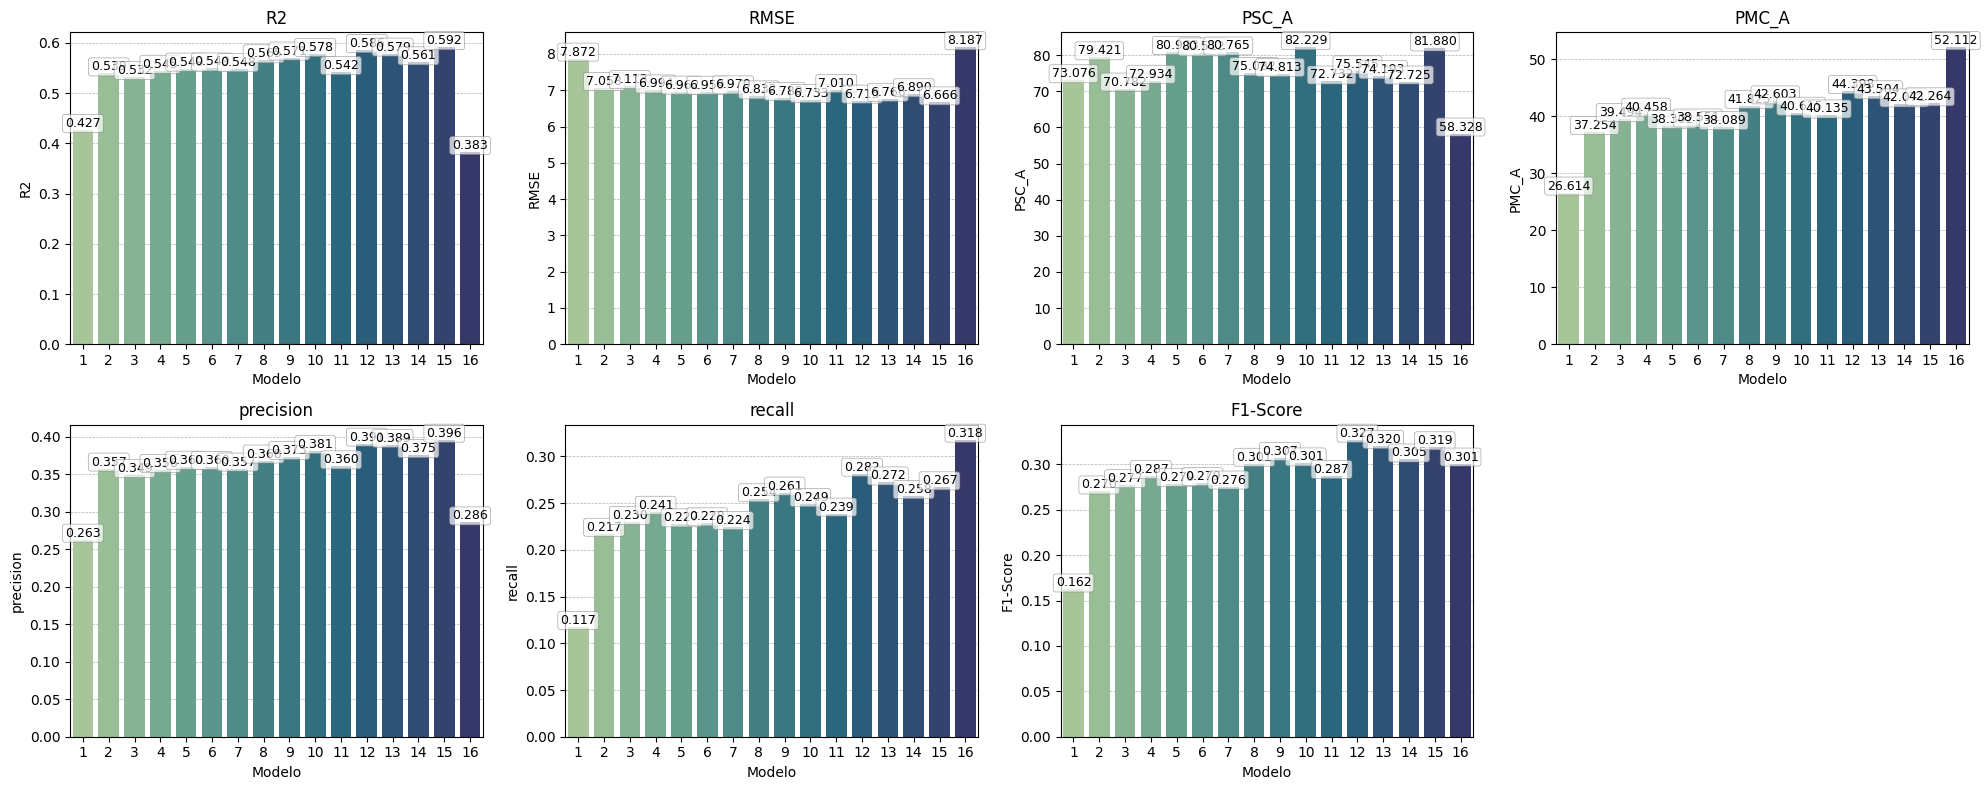

In [ ]:
plot_model_metrics(metrics_df, ['R2', 'RMSE','PSC_A','PMC_A','precision','recall','F1-Score'])

In [30]:
comparisons[16].loc[comparisons[16]['id_estacao']==8].sort_values('dt_medicao')

,id_estacao,latitude,longitude,dt_medicao,y_test,y_pred,model
17528,8,-22.9,-46.42,2000-01-01,29.3,22.517874,model_16
18924,8,-22.9,-46.42,2000-01-02,41.8,50.641579,model_16
17608,8,-22.9,-46.42,2000-01-03,7.6,44.596912,model_16
19091,8,-22.9,-46.42,2000-01-04,34.0,23.219538,model_16
17569,8,-22.9,-46.42,2000-01-05,9.6,55.394855,model_16
...,...,...,...,...,...,...,...
18768,8,-22.9,-46.42,2006-12-01,0.0,4.818267,model_16
2502,8,-22.9,-46.42,2006-12-02,0.0,1.153121,model_16
17658,8,-22.9,-46.42,2006-12-02,0.0,0.954445,model_16
18153,8,-22.9,-46.42,2006-12-03,0.0,0.907401,model_16


In [28]:
abt_estacoes_vizinhas.loc[abt_estacoes_vizinhas['id_estacao']==8].sort_values('dt_medicao')

,id_estacao,latitude,longitude,vl_declividade,vl_altitude,vl_distancia_oceano,vl_aspecto_relevo,dt_medicao,vl_precipitacao,vl_temperatura_maxima,...,vl_distancia_km_vizinha_9,vl_prioridade_vizinha_9,vl_precipitacao_vizinha_9,vl_correlacao_estacao_vizinha_10,pct_intersecao_precipitacao_vizinha_10,vl_distancia_km_vizinha_10,vl_prioridade_vizinha_10,vl_precipitacao_vizinha_10,dt_medicao_mes,dt_medicao_ano
1619500,8,-22.9,-46.42,5.53,829.0,106.79,143.75,2000-01-01,29.3,30.00,...,8.36,0.4022,18.6,0.596422,100.0,23.58,0.4015,24.5,1,2000
11279253,8,-22.9,-46.42,5.53,829.0,106.79,143.75,2000-01-02,41.8,30.00,...,8.36,0.4022,5.5,0.596422,100.0,23.58,0.4015,17.6,1,2000
2267878,8,-22.9,-46.42,5.53,829.0,106.79,143.75,2000-01-03,7.6,30.00,...,8.36,0.4022,38.0,0.596422,100.0,23.58,0.4015,36.5,1,2000
12438093,8,-22.9,-46.42,5.53,829.0,106.79,143.75,2000-01-04,34.0,22.00,...,8.36,0.4022,0.8,0.596422,100.0,23.58,0.4015,14.1,1,2000
1966832,8,-22.9,-46.42,5.53,829.0,106.79,143.75,2000-01-05,9.6,24.50,...,8.36,0.4022,43.1,0.596422,100.0,23.58,0.4015,28.8,1,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12192481,8,-22.9,-46.42,5.53,829.0,106.79,143.75,2006-11-29,35.0,28.46,...,8.36,0.4022,5.2,0.596422,100.0,23.58,0.4015,28.0,11,2006
4606975,8,-22.9,-46.42,5.53,829.0,106.79,143.75,2006-11-30,7.5,28.92,...,8.36,0.4022,0.4,0.596422,100.0,23.58,0.4015,0.0,11,2006
10205898,8,-22.9,-46.42,5.53,829.0,106.79,143.75,2006-12-01,0.0,27.76,...,8.36,0.4022,0.0,0.596422,100.0,23.58,0.4015,0.0,12,2006
2597063,8,-22.9,-46.42,5.53,829.0,106.79,143.75,2006-12-02,0.0,29.61,...,8.36,0.4022,0.0,0.596422,100.0,23.58,0.4015,0.0,12,2006


In [31]:
2523/5008

0.5037939297124601

## Comparando com os produtos

In [4]:
import duckdb
modelling_conn = duckdb.connect('modelling_db')

In [48]:
prata_conn = duckdb.connect('prata_db')
ouro_conn = duckdb.connect('ouro_db')

In [50]:
ouro_conn.execute("show tables").fetch_df()

,name
0,abt_estacoes
1,abt_produtos
2,dim_estacoes
3,fato_estacoes_base_fila_prioridade
4,fato_estacoes_correlacao
5,fato_estacoes_distancia
6,fato_estacoes_intersecao
7,fato_estacoes_latlon_produtos_df
8,fato_estacoes_precipitacao
9,fato_estacoes_temperatura_maxima


In [53]:
ouro_conn.execute("select COUNT(*) from fato_produto_chirps WHERE vl_precipitacao IS NOT NULL").fetch_df()

,count_star()
0,413652204


In [29]:
with pd.option_context("display.max_columns",None):
    display(modelling_conn.execute("SELECT * FROM abt_produtos LIMIT 10").fetch_df())

,id_estacao,latitude,longitude,vl_declividade,vl_altitude,vl_distancia_oceano,vl_aspecto_relevo,dt_medicao,vl_precipitacao,vl_temperatura_maxima,vl_temperatura_media,vl_temperatura_minima,vl_umidade_relativa_maxima,vl_umidade_relativa_media,vl_umidade_relativa_minima,vl_velocidade_vento_2m_maxima,vl_velocidade_vento_2m_media,vl_velocidade_vento_10m_media,vl_precipitacao_chirps,vl_precipitacao_cpc,vl_temperatura_maxima_cpc,vl_temperatura_minima_cpc,vl_precipitacao_gpm_final_run,vl_precipitacao_gpm_late_run,vl_precipitacao_power,vl_temperatura_maxima_2m_K_power,vl_temperatura_media_2m_K_power,vl_temperatura_minima_2m_K_power,vl_umidade_relativa_2m_power,vl_pressao_nivel_superficie_power,vl_irradiancia_allsky_power,vl_direcao_vento_10m_power,vl_direcao_vento_2m_power,vl_temperatura_orvalho_2m_K_power,vl_vento_10m_power,vl_vento_medio_2m_power,vl_vento_maximo_2m_power,vl_vento_maximo_10m_power
0,575135,-22.8880,-46.9390,1.44,0.0,123.11,221.63,2020-10-14,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.17,3.367000e+01,1.877000e+01,NaN,15.0,0.533059,307.604688,298.470312,291.457812,59.3750,91671.9500,232.457031,181.8500,188.3000,288.304688,3.128125,1.812500,3.079687,5.126563
1,574962,-22.1560,-42.4190,10.32,0.0,62.97,333.14,2021-04-18,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,2.734000e+01,1.772000e+01,NaN,1.0,1.718643,303.314062,298.231250,295.301562,79.4750,99536.5125,195.761719,76.7625,77.0750,294.015625,2.896875,2.131250,3.625000,4.782813
2,574707,-23.3330,-44.6780,7.76,0.0,0.76,242.95,2019-06-14,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.945000e+01,1.440000e+01,NaN,0.0,0.001001,298.371875,296.795313,295.656250,84.5250,100821.7125,175.093750,135.9375,99.9500,293.978125,2.198437,1.842188,2.765625,3.307812
3,921899,-19.5536,-52.1664,1.33,395.0,732.83,325.95,2006-12-03,4.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.56,2.967000e+01,2.211000e+01,NaN,0.0,6.256551,304.375000,299.685938,296.889063,81.6375,96037.4625,221.312500,212.7375,212.6375,296.009375,3.935938,2.598438,5.232812,7.454688
4,923748,-21.3136,-46.8722,4.08,785.0,287.45,263.29,2015-08-05,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,2.731000e+01,1.282000e+01,NaN,0.0,0.017414,301.198438,292.460938,285.045313,52.8500,91721.4125,223.445312,114.8875,118.8875,281.481250,2.528125,1.237500,2.123438,3.723438
5,577918,-21.8680,-43.3130,5.40,0.0,92.80,214.22,2015-12-27,2.178695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,3.050000e+01,1.925000e+01,NaN,0.0,1.006591,303.587500,297.951563,293.182813,74.8125,94377.7125,303.544922,277.7750,277.3000,292.754687,3.956250,2.468750,4.123437,6.118750
6,1177,-21.1817,-45.0583,2.34,788.0,205.76,75.26,2013-03-23,0.000000,25.0,20.5,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.98,3.090000e+01,1.825000e+01,NaN,4.0,1.907926,299.656250,294.484375,291.539062,85.6875,90698.4375,238.640625,116.1875,114.6250,291.820312,2.734375,1.812500,2.953125,4.507812
7,924569,-22.1061,-41.4711,0.30,10.0,11.01,168.69,2006-03-25,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,-9.969210e+36,-9.969210e+36,NaN,0.0,0.021539,300.590625,299.860937,299.189062,84.5750,101214.6750,253.421875,30.5375,30.5000,297.042188,7.510937,6.339062,7.473438,8.889062
8,575319,-23.1846,-46.4010,7.63,0.0,76.09,207.06,2015-08-18,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2.514000e+01,1.585000e+01,NaN,9.0,0.000008,300.467188,293.867188,288.695312,57.8250,94342.0375,145.382812,229.3250,223.5500,284.659375,3.682812,2.354687,3.954687,5.479687
9,1227,-19.4758,-45.6056,3.84,732.0,404.02,228.14,2005-02-17,0.000000,29.0,24.5,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.84,3.093000e+01,2.073000e+01,NaN,10.0,5.019817,302.590625,297.339063,292.051562,81.8500,93199.8375,195.500000,98.0375,98.0500,293.759375,2.043750,1.351562,2.798437,3.873438


In [23]:
df_chirps = modelling_conn.execute("""
SELECT
    id_estacao,
    dt_medicao,
    vl_precipitacao,
    vl_precipitacao_chirps
FROM abt_produtos
WHERE vl_precipitacao_chirps IS NOT NULL
""").fetch_df()

df_gpm_final = modelling_conn.execute("""
SELECT
    id_estacao,
    dt_medicao,
    vl_precipitacao,
    vl_precipitacao_gpm_final_run
FROM abt_produtos
WHERE vl_precipitacao_gpm_final_run IS NOT NULL
""").fetch_df()

df_gpm_late = modelling_conn.execute("""
SELECT
    id_estacao,
    dt_medicao,
    vl_precipitacao,
    vl_precipitacao_gpm_late_run
FROM abt_produtos
WHERE vl_precipitacao_gpm_late_run IS NOT NULL
""").fetch_df()

df_power = modelling_conn.execute("""
SELECT
    id_estacao,
    dt_medicao,
    vl_precipitacao,
    vl_precipitacao_power
FROM abt_produtos
WHERE vl_precipitacao_power IS NOT NULL
""").fetch_df()

In [24]:
df_chirps

,id_estacao,dt_medicao,vl_precipitacao,vl_precipitacao_chirps


In [30]:
compute_metrics(df_power['vl_precipitacao'],df_power['vl_precipitacao_power'])

{'precision': 0.12098644657965943,
 'recall': 0.061618829063093135,
 'F1-Score': 0.08165200205198965,
 'RMSE': 9.903875438489928,
 'R2': 0.09340564857783595,
 'MAE': 4.185496052918744,
 'PSC_A': 73.01404739022026,
 'PCC_A': 69.6788355292568,
 'PMC_A': 15.299255129154506}

In [ ]:
compute_metrics(comparisons[model_number]['y_test'],comparisons[model_number]['y_pred'])

In [9]:
[c for c in modelling_conn.execute("SELECT * FROM abt_estacoes_3_vizinhas LIMIT 1").fetch_df().columns if 'precipitacao' in c and not 'vizinha' in c]

['vl_precipitacao',
 'vl_precipitacao_chirps',
 'vl_precipitacao_cpc',
 'vl_precipitacao_gpm_final_run',
 'vl_precipitacao_gpm_late_run',
 'vl_precipitacao_power']

## Análise por estações

In [7]:
estacoes = comparisons[1]['id_estacao'].unique()
dim_lat_lon = comparisons[1][['id_estacao','latitude','longitude']].drop_duplicates()

comparisons_estacoes = {
    model_number:{
        id_estacao:comparisons[model_number].loc[comparisons[model_number]['id_estacao']==id_estacao].copy() 
        for id_estacao in estacoes} 
    for model_number in comparisons.keys()}

metrics_estacoes = {
    model_number:{
        id_estacao:compute_metrics(comparisons_estacoes[model_number][id_estacao]['y_test'],comparisons_estacoes[model_number][id_estacao]['y_pred']) 
        for id_estacao in estacoes} 
    for model_number in comparisons.keys()}

dados = []
for model_number, estacoes_dict in metrics_estacoes.items():
    for id_estacao, metricas in estacoes_dict.items():
        linha = {"model_number": model_number, "id_estacao": id_estacao}
        linha.update(metricas)
        dados.append(linha)

df_metricas = pd.DataFrame(dados)
df_metricas = df_metricas.merge(dim_lat_lon,on='id_estacao',how='left')


C:\Users\Mateus Santos Rochas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Mateus Santos Rochas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Mateus Santos Rochas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Mateus Santos Rochas\AppData\Local\Pa

c:\Users\Mateus Santos Rochas\Desktop\Estudos\07. Doutorado - Matemática aplicada\Pesquisa\Dados Novos\comparison_utils.py:121: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  brasil_estados = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


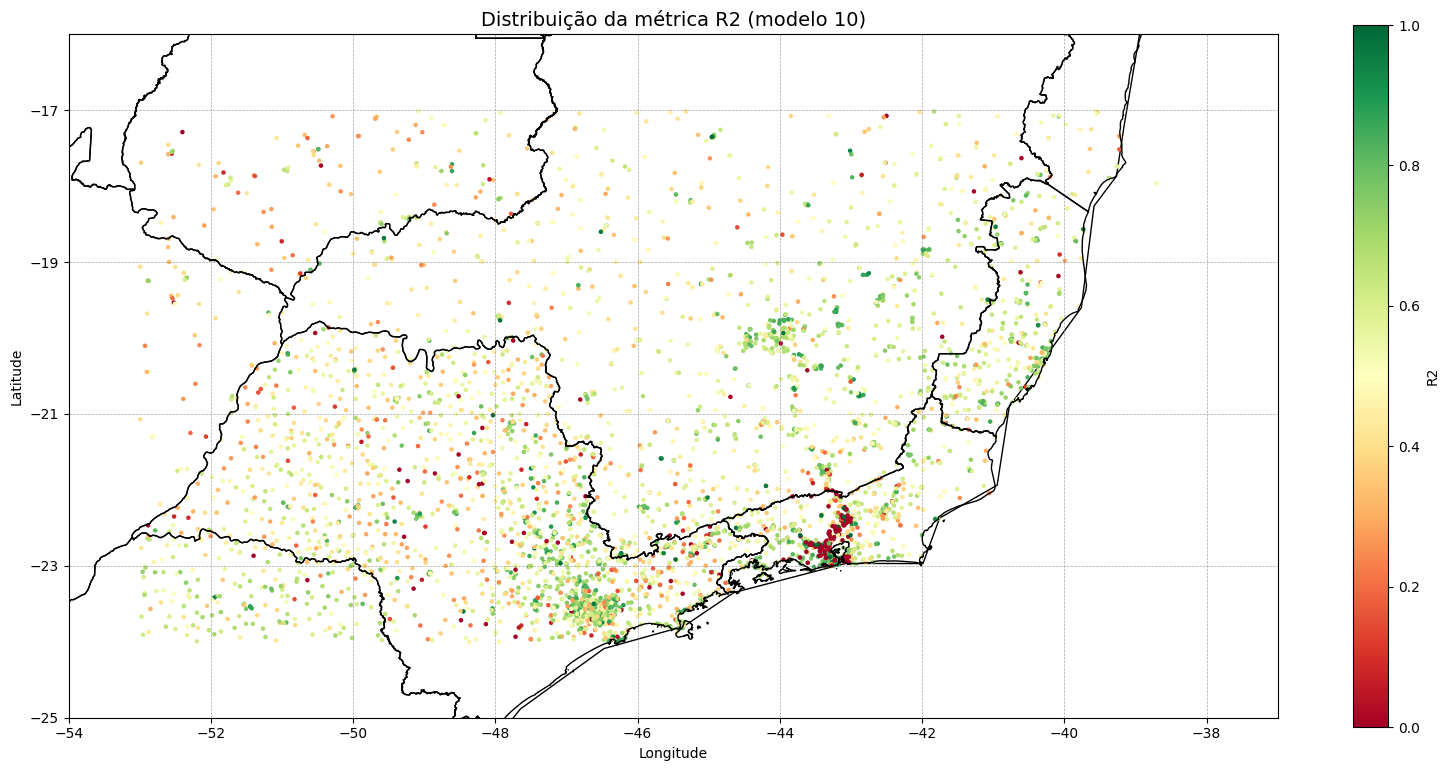

In [8]:
plot_metrica_heatmap(df_metricas, 'R2',model_number=10,figsize=(16,12),markersize=5)

# ANALISES INDIVIDUAIS

In [9]:
from comparison_utils import get_all_comparisons,get_metrics_per_station,plot_model_prediction_vs_observation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
model_numbers = [1,2,3,4,5,6,7,8,9,10]
comparison_df = get_all_comparisons(model_numbers)
count_medicoes_df = comparison_df.groupby(['model','id_estacao'],as_index=False).agg(count_medicoes=('y_test','count'))

metrics_per_station_df = get_metrics_per_station(comparison_df)
metrics_per_station_df = metrics_per_station_df.merge(count_medicoes_df,left_on=['model_number','id_estacao'],right_on=['model','id_estacao'],how='left')

C:\Users\Mateus Santos Rochas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Mateus Santos Rochas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Mateus Santos Rochas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Mateus Santos Rochas\AppData\Local\Pa

In [11]:
model_number = 10
min_count_medicoes = 100
metric = 'R2'
ascending = False

metrics_per_station_df.loc[
    (metrics_per_station_df['model_number']==f'model_{model_number}')
    & (metrics_per_station_df['count_medicoes']>=min_count_medicoes)].sort_values(by=metric,ascending=ascending).head()

,model_number,id_estacao,precision,recall,F1-Score,RMSE,R2,MAE,PSC_A,PCC_A,PMC_A,latitude,longitude,model,count_medicoes
6370,model_10,920341,0.965171,0.967894,0.966530,1.044169,0.986951,0.419367,96.829971,99.472991,97.500000,-17.3500,-44.9500,model_10,3188
7119,model_10,925311,0.976553,0.936604,0.956161,1.631661,0.983262,0.664382,96.571429,98.888889,95.744681,-22.6500,-44.5833,model_10,530
6480,model_10,921795,0.982738,0.977561,0.980142,1.444058,0.980676,0.721560,92.009029,99.646955,98.837209,-19.7667,-47.9333,model_10,3348
4443,model_10,30,0.959847,0.977215,0.968453,1.591676,0.978199,0.703511,96.003996,99.805825,99.242424,-21.1700,-47.8000,model_10,1516
4469,model_10,65,0.943106,0.944624,0.943865,1.736223,0.975590,0.757007,96.032553,99.437148,97.810219,-21.1700,-47.8000,model_10,1516


In [12]:
model_number = 10
id_estacao = 925311
plot_model_prediction_vs_observation(comparison_df, model_number=model_number, id_estacao=id_estacao,figsize=(18, 6))

TypeError: plot_model_prediction_vs_observation() got an unexpected keyword argument 'figsize'

In [ ]:
comparisons[10].loc[comparisons[10]['id_estacao']==id_estacao].head()

,id_estacao,latitude,longitude,dt_medicao,y_test,y_pred,model
2848687,925311,-22.65,-44.5833,2002-04-11,0.0,0.0,model_10
2848688,925311,-22.65,-44.5833,2002-04-12,0.0,0.0,model_10
2848689,925311,-22.65,-44.5833,2002-04-13,0.0,0.0,model_10
2848690,925311,-22.65,-44.5833,2002-04-14,0.0,0.0,model_10
2848691,925311,-22.65,-44.5833,2002-04-15,0.0,0.0,model_10


In [ ]:
len(estacoes)

4420

In [ ]:
# Conferir se to validando no lugar correto
# >  Ex: estação 920341 ta com dados desde 2000, nao deveria
# > Testar mais limiares pro bi_model
# > Investigar estçaões do ES
# > Implementar o SmoteR
# > Correlação entre o indice da melhor estação e o R2